# 🔧 环境配置和检查

## 概述
本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：
- 使用统一的conda环境
- 通过国内镜像源快速安装依赖
- 加速模型下载
- 检查系统配置

## 配置步骤
1. **Conda环境管理** - 激活统一的学习环境
2. **包管理器优化** - 配置pip使用清华镜像源
3. **模型下载加速** - 设置HuggingFace镜像代理
4. **系统环境诊断** - 检查硬件和软件配置


In [ ]:
# 1. 激活conda环境
%%script bash
# 初始化 conda
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action
conda env list


In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-5/memory_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 具备记忆能力的聊天机器人

## 回顾

[记忆](https://pmc.ncbi.nlm.nih.gov/articles/PMC10410470/)是人类的一种认知功能，用于存储、检索和使用信息，从而更好地理解当下与未来。

在 AI 应用中可以利用[多种长期记忆类型](https://langchain-ai.github.io/langgraph/concepts/memory/#memory)。

## 目标

本节将介绍 [LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)——一种在系统中保存与检索长期记忆的机制。

我们将构建一个同时使用`短期记忆（单线程内）`与`长期记忆（跨线程）`的聊天机器人。

**这里重点关注长期的[语义记忆](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory)，即关于用户的客观事实信息。**

**这些长期记忆将用于个性化对话，使机器人能够“记住”用户信息。**

记忆会在对话过程中[实时写入（hot path）](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories)。 为初学者：可将其理解为“边聊边记”，无需单独的离线处理环节。

In [1]:
%%capture --no-stderr
# %pip install -U langchain_openai langgraph langchain_core
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行[调用链追踪（tracing）](https://docs.smith.langchain.com/concepts/tracing)，便于观察每一步推理与存取记忆的过程。

In [2]:
import os, getpass

# 读取或安全输入环境变量的小工具函数
# 若未在系统环境中设置，则在运行时提示输入（避免把密钥写入代码）
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# LangSmith 相关配置（用于追踪与可观测性）
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "FlyAIBox"

LANGSMITH_API_KEY: ··········


## LangGraph Store 简介

[LangGraph Memory Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) 提供了在 LangGraph 中于“跨线程（across threads）”范围内存取信息的能力。

它是一个用于持久化 `key-value` 存储的[开源基础类](https://blog.langchain.dev/launching-long-term-memory-support-in-langgraph/)。初学者可将其理解为“分层命名空间 + 键值对”的抽象：在不同用户、不同会话之间进行隔离管理。

In [3]:
import uuid
from langgraph.store.memory import InMemoryStore

# 初始化内存型 Store（适合示例与本地开发，生产可替换为持久化实现）
in_memory_store = InMemoryStore()

当我们将对象（如“记忆”）保存到[Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) 时，需要提供：

- `namespace`（命名空间）：一个元组，类似多级目录
- `key`（键）：类似文件名
- `value`（值）：类似文件内容

使用 [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) 方法按 `namespace` 与 `key` 将对象写入存储。


为初学者：`namespace` 常用来表示“用户 ID + 分类”，例如 `(user_id, "memories")`，从而区分不同用户与不同类型的长期记忆。

In [4]:
# 要保存记忆的命名空间（跨用户/分类进行隔离）
user_id = "1"
namespace_for_memory = (user_id, "memories")

# 在该命名空间下生成一个唯一键（类似文件名）
key = str(uuid.uuid4())

# 值需为字典（便于后续扩展与合并）
value = {"食物偏好" : "我喜欢披萨"}

# 写入记忆
in_memory_store.put(namespace_for_memory, key, value)

我们使用 [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search) 按 `namespace` 从存储中检索对象。

该方法返回一个列表。

In [5]:
# 查询（按命名空间检索）
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [6]:
# 元数据
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '47425283-5656-4103-87bc-1e40ded68077',
 'value': {'食物偏好': '我喜欢披萨'},
 'created_at': '2025-09-17T07:41:14.916499+00:00',
 'updated_at': '2025-09-17T07:41:14.916502+00:00',
 'score': None}

In [7]:
# 键与值
print(memories[0].key, memories[0].value)

47425283-5656-4103-87bc-1e40ded68077 {'食物偏好': '我喜欢披萨'}


我们也可以使用 [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) 通过 `namespace` 与 `key` 来获取对象。

In [8]:
# 通过命名空间与键获取记忆
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '47425283-5656-4103-87bc-1e40ded68077',
 'value': {'食物偏好': '我喜欢披萨'},
 'created_at': '2025-09-17T07:41:14.916499+00:00',
 'updated_at': '2025-09-17T07:41:14.916502+00:00'}

## 拥有长期记忆的聊天机器人

我们希望聊天机器人[具备两类记忆](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_156)：

1. `短期记忆（单线程内）`：在同一会话线程中，持续保存对话历史，并可支持中断/恢复。
2. `长期记忆（跨线程）`：在所有会话中，持续记住特定用户的相关信息。

In [9]:
# 设置OpenAI API密钥
# 您需要从 https://api.apiyi.com/v1 获取API密钥
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


对于`短期记忆`，我们将使用[检查点（checkpointer）](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries)。

更多细节可参考第 2 模块与[持久化概念文档](https://langchain-ai.github.io/langgraph/concepts/persistence/)。简而言之：

* 在每一步将图的状态写入某个线程（thread）。
* 在线程中持久化聊天历史。
* 允许从线程中的任意一步进行中断与恢复。

而对于`长期记忆`，我们将使用上文介绍的 [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)。

In [10]:
# 聊天模型
from langchain_openai import ChatOpenAI

# 初始化 LLM
model = ChatOpenAI(model="gpt-4o", temperature=0)

聊天历史会通过 checkpointer 保存在短期记忆中。

随后，聊天机器人会“反思”聊天历史。

并基于历史生成新的长期记忆并写入 [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)。

这些长期记忆会在未来会话中被读取，从而实现个性化回复。

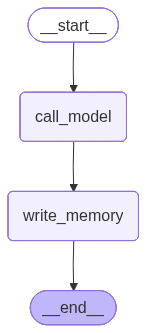

In [11]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# 聊天机器人系统提示（说明如何使用已有记忆进行个性化）
MODEL_SYSTEM_MESSAGE = """您是一个具有记忆力的有帮助的助手，可以提供有关用户的信息。如果您有关于此用户的记忆，请使用它来个性化您的回复。以下是记忆（可能为空）：{memory}"""

# 从聊天历史与现有记忆中提炼并生成新的长期记忆（写入 Store）
CREATE_MEMORY_INSTRUCTION = """"您正在收集用户信息以个性化您的回复。

当前用户信息：
{memory}

指令：
1. 仔细回顾以下聊天记录
2. 识别关于用户的新信息，例如：
   - 个人详细信息（姓名、位置）
   - 偏好（喜欢、不喜欢）
   - 兴趣和爱好
   - 过往经历
   - 目标或未来计划
3. 将任何新信息与现有记忆合并
4. 将记忆格式化为清晰的、项目符号列表
5. 如果新信息与现有记忆冲突，保留最新版本

请记住：只包含用户直接陈述的事实信息。不要做假设或推断。

根据以下聊天记录，请更新用户信息："""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    调用语言模型，并利用长期记忆进行个性化回复。

    Args:
        state (MessagesState): 当前图的状态，包含了聊天历史。
        config (RunnableConfig): 运行配置，包含可配置参数，如用户 ID。
        store (BaseStore): 用于存储和检索长期记忆的 Store 实例。

    Returns:
        dict: 包含模型回复消息的字典。
    """

    # 从配置中获取用户 ID（用于命名空间隔离，区分不同用户的记忆）
    user_id = config["configurable"]["user_id"]

    # 从存储中读取该用户的长期记忆
    # 命名空间 (namespace) 用于组织数据，这里使用 ("memory", user_id) 来表示特定用户的记忆空间
    # 键 (key) 用于唯一标识存储的对象，这里使用 "user_memory"
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # 提取记忆内容（存储的值是一个字典，实际记忆内容存储在 'memory' 键下）
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found." # 如果没有找到记忆，则使用默认提示

    # 将用户的长期记忆注入到系统提示中，用于个性化模型回复
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)

    # 调用语言模型生成回复
    # 输入包括带有注入记忆的系统提示和当前的聊天历史
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    # 返回更新后的状态，将模型的回复添加到消息列表中
    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    反思聊天历史，提取新的用户信息，并更新长期记忆到 Store 中。

    Args:
        state (MessagesState): 当前图的状态，包含了聊天历史。
        config (RunnableConfig): 运行配置，包含可配置参数，如用户 ID。
        store (BaseStore): 用于存储和检索长期记忆的 Store 实例。
    """

    # 从配置中获取用户 ID
    user_id = config["configurable"]["user_id"]

    # 从存储中检索该用户的现有长期记忆
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 提取现有记忆内容
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found." # 如果没有找到记忆，则使用默认提示

    # 准备用于生成新记忆的系统提示
    # 将现有记忆和聊天历史注入到 CREATE_MEMORY_INSTRUCTION 提示中
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # 将提炼出的新记忆写入（或覆盖）Store 中的现有长期记忆
    # 键 (key) 仍然是 "user_memory"
    # 值 (value) 存储为一个字典 {"memory": new_memory.content}
    key = "user_memory"
    store.put(namespace, key, {"memory": new_memory.content})

# 定义图（节点与边）
# StateGraph 用于构建基于状态的图
builder = StateGraph(MessagesState)

# 添加节点，将 call_model 和 write_memory 函数注册为图中的节点
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

# 定义边，指定节点之间的流程顺序
# 从 START 节点开始，首先进入 "call_model" 节点
builder.add_edge(START, "call_model")
# 从 "call_model" 节点处理完成后，进入 "write_memory" 节点
builder.add_edge("call_model", "write_memory")
# 从 "write_memory" 节点处理完成后，结束当前流程，进入 END 节点
builder.add_edge("write_memory", END)

# 初始化长期记忆（跨线程）存储实例
# InMemoryStore 是一个简单的内存存储实现，适合示例和本地开发
# 在生产环境中，需要使用持久化的 Store 实现，如 RedisStore, PostgresStore 等
across_thread_memory = InMemoryStore()

# 初始化短期记忆（单线程）检查点实现
# MemorySaver 用于在单个会话线程中保存和恢复聊天历史
within_thread_memory = MemorySaver()

# 编译图：将定义的节点和边连接起来，并挂载短期记忆检查点与长期记忆存储实例
# checkpointer 参数用于配置短期记忆
# store 参数用于配置长期记忆
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# 可视化查看图结构
# get_graph() 方法用于获取图的结构信息
# xray=1 参数通常用于显示更详细的图信息
# draw_mermaid_png() 方法将图结构转换为 Mermaid 格式并渲染为 PNG 图片，便于理解图的流程
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

与聊天机器人交互时，我们需要提供两类标识：

1. `短期记忆（单线程内）`：提供 `thread ID` 以持久化该线程的聊天历史。
2. `长期记忆（跨线程）`：提供 `user ID` 用作命名空间前缀，将长期记忆与特定用户绑定。

下面一起看看它们如何协同工作。

In [12]:
# 提供线程 ID（短期记忆）
# 提供用户 ID（长期记忆）
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# 用户输入
input_messages = [HumanMessage(content="嗨，我是FLY")]

# 运行图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

嗨，我是FLY
================================== Ai Message ==================================

嗨，FLY！很高兴认识你！有什么我可以帮忙的吗？


In [13]:
# 用户输入
input_messages = [HumanMessage(content="我喜欢在湖边骑自行车")]

# 运行图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我喜欢在湖边骑自行车
================================== Ai Message ==================================

那听起来很棒，FLY！湖边骑自行车一定很惬意吧，微风拂面，风景优美。你通常喜欢在早晨、傍晚，还是某个特定的季节骑车呢？或者，有没有什么特别的湖是你最喜欢的？


我们使用 `MemorySaver` 作为单线程内（短期）记忆的检查点实现。

它会把聊天历史保存到对应的线程。

我们可以查看该线程中保存的聊天历史。

In [14]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]:
    # 逐条打印该线程保存的消息
    m.pretty_print()

================================ Human Message =================================

嗨，我是FLY
================================== Ai Message ==================================

嗨，FLY！很高兴认识你！有什么我可以帮忙的吗？
================================ Human Message =================================

我喜欢在湖边骑自行车
================================== Ai Message ==================================

那听起来很棒，FLY！湖边骑自行车一定很惬意吧，微风拂面，风景优美。你通常喜欢在早晨、傍晚，还是某个特定的季节骑车呢？或者，有没有什么特别的湖是你最喜欢的？


回顾一下，我们在编译图时配置了用于长期记忆（跨线程）的存储：

```python
across_thread_memory = InMemoryStore()
```

同时，我们在图中添加了一个节点（`write_memory`），该节点会“反思”聊天历史并把记忆写入存储。

现在我们来验证记忆是否已保存到存储中。

In [15]:
# 验证：从跨线程存储中读取该用户的长期记忆
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': '**更新的用户信息：**\n\n- 名字：FLY\n- 兴趣和爱好：\n  - 喜欢在湖边骑自行车'},
 'created_at': '2025-09-17T07:42:14.259762+00:00',
 'updated_at': '2025-09-17T07:42:14.259765+00:00'}

接下来我们以“相同的用户 ID”启动“新的线程”。

此时应当看到：机器人能够基于长期记忆中的用户画像进行个性化回复。

In [16]:
# 提供相同的用户 ID（长期记忆），以及一个新的线程 ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# 用户输入
input_messages = [HumanMessage(content="嗨！你推荐我去哪里骑自行车？")]

# 运行图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

嗨！你推荐我去哪里骑自行车？
================================== Ai Message ==================================

嗨，FLY！知道你喜欢在湖边骑自行车，我觉得这是个很棒的爱好！以下是一些适合骑行的湖边地点推荐，希望能激发你的兴趣：

1. **杭州西湖（中国）**  
   西湖的骑行道风景如画，环湖一圈大约15公里，既能欣赏湖光山色，又能感受浓厚的文化气息。

2. **日内瓦湖（瑞士）**  
   如果你有机会去欧洲，日内瓦湖周围的骑行路线非常适合喜欢湖边骑行的人。湖水清澈，周围还有阿尔卑斯山的壮丽景色。

3. **太湖（中国江苏/浙江）**  
   太湖的环湖骑行路线非常受欢迎，尤其是鼋头渚附近，湖面开阔，风景优美。

4. **千岛湖（中国浙江）**  
   千岛湖的骑行道非常适合喜欢自然风光的人，湖中星罗棋布的小岛让骑行体验更加独特。

5. **明尼哈哈湖（美国明尼苏达州）**  
   如果你喜欢安静的湖边骑行，这里是个不错的选择，周围还有很多绿地和公园。

如果你有具体的时间或地点限制，可以告诉我，我再帮你推荐更合适的地方！另外，如果你最近有计划骑行，记得带好装备，注意安全哦！


In [17]:
# 用户输入
input_messages = [HumanMessage(content="太好了，附近有我可以去的咖啡店吗？我骑自行车后喜欢来喝一杯咖啡。")]

# 运行图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

太好了，附近有我可以去的咖啡店吗？我骑自行车后喜欢来喝一杯咖啡。
================================== Ai Message ==================================

骑完自行车后喝一杯咖啡，真是再惬意不过了！FLY，我不知道你目前的具体位置，但我可以给你一些建议，帮助你找到适合的咖啡店：

1. **骑行路线附近的独立咖啡店**  
   很多湖边骑行路线附近都会有一些独立咖啡店，它们通常有独特的氛围和手工咖啡。如果你骑行的地方是热门景点，试着在地图上搜索“咖啡”或“咖啡馆”，看看附近的推荐。

2. **连锁咖啡店**  
   如果你喜欢稳定的口味，像星巴克、Costa Coffee 或 Luckin Coffee（瑞幸咖啡）这样的连锁店通常很容易找到。

3. **湖边咖啡馆**  
   有些湖边会有专门的湖景咖啡馆，边喝咖啡边欣赏湖景，绝对是骑行后的完美放松方式。

如果你告诉我你骑行的具体湖边位置，我可以帮你查找附近的咖啡店，甚至推荐一些评价不错的店铺！或者，如果你有偏好的咖啡类型（比如手冲、拿铁、冷萃），也可以告诉我，我会帮你找到更符合你口味的地方！


## 在 LangSmith 中查看追踪

你可以看到长期记忆会从存储中被读取，并作为系统提示的一部分传入模型（符合预期）：

https://smith.langchain.com/o/7bfa9385-4ac5-468a-a06c-ffd7dbac42ec/projects/p/27f0e396-e7ab-4eac-9501-8df28b729149?timeModel=%7B%22duration%22%3A%227d%22%7D&peek=3068d3e2-cb03-4564-8cda-cc7679b09d24&peeked_trace=c1df4e6a-ca89-47fa-bd59-fb83ca4fc24c&runtab=0

![在 LangSmith 中查看追踪](https://cdn.jsdelivr.net/gh/Fly0905/note-picture@main/imag/202509171549387.png)